안녕하세요.

본 대회의 데이터 셋에는 **PCA**가 적합하다 생각되어 적용했고, 

간단하게 **Noisy Student B7** 모델을 사용했습니다.

Ubuntu 20.04(2 GPUs), Windows 11(Single GPU)에서 재현 테스트 완료했습니다.

학습에 사용한 워크스테이션의 환경은 다음과 같습니다.

* CPU: 2x Intel(R) Xeon(R) Gold 5218R CPU @ 2.10GHz
* RAM: 192GB
* GPU: 2x NVIDIA RTX A4000 16GB (Compute Capability: 8.6)
* OS: Ubuntu 20.04 / Windows 11 Pro for Workstations 21H2
* PYTHON: 3.8
* PYTORCH: 1.12.1
* CUDA: 11.6

**감사합니다.**

<hr/>

#### 코드

In [2]:
import os
from glob import glob
import random
import time
import copy
import datetime as dt
import warnings
from collections import Counter
import itertools
import shutil

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import plotly.express as px
import wandb
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from efficientnet_pytorch import EfficientNet
import albumentations as A
import albumentations.pytorch
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from joblib import parallel_backend
import ttach as tta
import timm
from timm.models.layers import Conv2dSame
import platform

In [2]:
warnings.filterwarnings(action='ignore') 
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M%S")

def seed_everything(seed: int=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

seed_everything(42)

전처리 후 train.csv를 새로 만들 것입니다.

In [3]:
os.rename("./data/train.csv", "./data/train_og.csv")

In [4]:
!ls -l

total 24
drwxrwxr-x 2 syu syu  4096  9월  9 18:15 data
-rw-rw-r-- 1 syu syu 20327  9월  9 18:15 reproduce.ipynb


In [5]:
!ls -l ./data

total 10069000
-rw-rw-r-- 1 syu syu     360009  9월  9 18:07 sample_submission.csv
-rw-rw-r-- 1 syu syu 9323884762  9월  9 18:08 test.h5
-rw-rw-r-- 1 syu syu  986006413  9월  9 18:08 train.h5
-rw-rw-r-- 1 syu syu     388899  9월  9 18:08 train_og.csv


<hr/>

# 1. 데이터 전처리

PCA는 아래의 코드를 참고했습니다.

https://github.com/rickiepark/handson-ml2/blob/master/08_dimensionality_reduction.ipynb

훈련 세트의 데이터 10개 정도를 Scikit-Learn의 여러 PCA 알고리즘들을 사용하여 축소해 봤는데, 

**Random PCA**가 가장 적합하다고 생각되어 선택했습니다.

제 CPU를 기준으로 훈련 세트는 약 3시간, 테스트 세트는 약 2시간 30분이 소요되었습니다.

**60기가 이상의 RAM을 사용합니다. 주의해주세요.**

In [8]:
for f in range(10):
    os.makedirs(f'./data/train_tmp/{f}/', exist_ok=True)
os.makedirs('./data/test/', exist_ok=True)

rnd_pca = PCA(n_components=2, svd_solver="randomized", random_state=41)

all_points = h5py.File('./data/train.h5', 'r')
all_df = pd.read_csv('./data/train_og.csv')
all_points = [np.array(all_points[str(i)]) for i in tqdm(all_df["ID"])]
labels = all_df['label'].values

for i, point in enumerate(tqdm(all_points)):
    with parallel_backend('threading', n_jobs=40):
        point2D_pca = rnd_pca.fit_transform(point)
    plt.plot(point2D_pca[:, 0], point2D_pca[:, 1], color='black', marker='.', markersize=10)
    plt.axis('off')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'./data/train_tmp/{labels[i]}/{i}.jpg', format='jpg', dpi=200)
    plt.clf()

test_points = h5py.File('./data/test.h5', 'r')
test_df = pd.read_csv('./data/sample_submission.csv')
test_points = [np.array(test_points[str(i)]) for i in tqdm(test_df["ID"])]

for i, point in enumerate(tqdm(test_points)):
    with parallel_backend('threading', n_jobs=40):
        point2D_pca = rnd_pca.fit_transform(point)
    plt.plot(point2D_pca[:, 0], point2D_pca[:, 1], color='black', marker='.', markersize=10)
    plt.axis('off')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'./data/test/{str(i).rjust(5, "0")}.jpg', format='jpg', dpi=200)
    plt.clf()

100%|██████████| 40000/40000 [2:33:00<00:00,  4.36it/s]  


<Figure size 640x480 with 0 Axes>

<hr/>

시각화 예시.

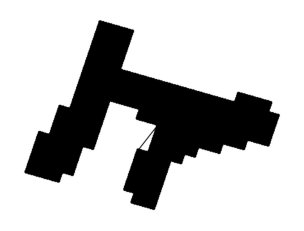

In [7]:
# %matplotlib inline
# plt.axis('off')

# qqqq = Image.open('./24.jpg')
# plt.imshow(qqqq)

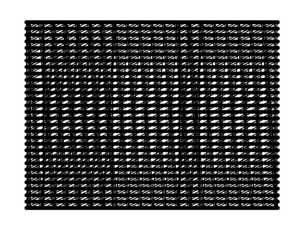

In [18]:
# %matplotlib inline
# plt.axis('off')

# qqqqq = Image.open('./8.jpg')
# plt.imshow(qqqqq)

PCA 후 훈련 세트 몇 장을 살펴봤는데, 클래스 "1"의 이미지 중 일부가 두 번째 이미지처럼 노이즈로 변환된 것을 확인했습니다.

이를 분리하기 위해 평균 픽셀 값들을 히스토그램으로 나타내봤고, 

어림잡아 123을 임곗값으로 정하여 **노이즈 이미지들을 클래스 "10"으로 따로 분리했습니다.**

이후 색이 연하여 제대로 분리되지 않은 노이즈 이미지들을 직접 찾아 옮겼습니다.

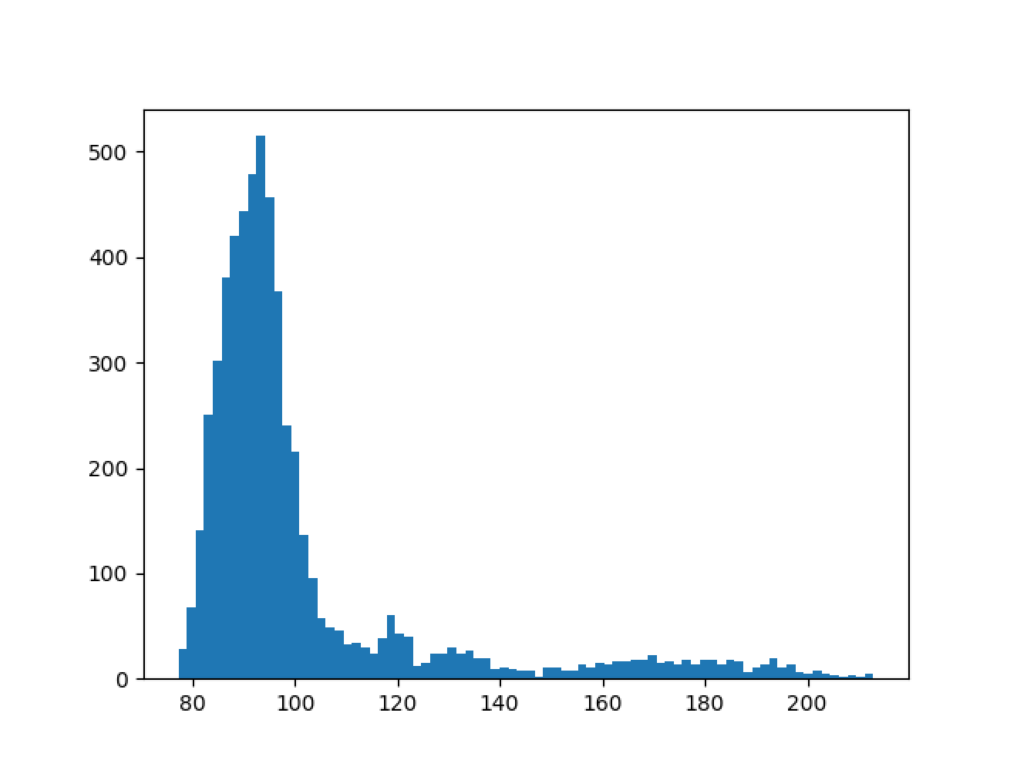

<Figure size 432x288 with 0 Axes>

In [17]:
# qqqqqq = Image.open('./histogram.png')
# fig, ax = plt.subplots(dpi=200)
# ax.imshow(qqqqqq)
# ax.axis('off')
# plt.tight_layout()
# plt.show()
# plt.clf()

In [9]:
image_list = glob('./data/train_tmp/1/*.jpg')
os.makedirs('./data/train_tmp/10/', exist_ok=True)

l=[]
label_list = pd.read_csv('./data/train_og.csv')

for i, image in enumerate(image_list):
    # LINUX: '\\' --> '/'
    # image_id = image.split('\\')[-1]
    image_id = image.split('/')[-1]
    image_id = int(image_id.split('.')[0])
    img = cv2.imread(image)
    m = sum(list(cv2.mean(img)))/3
    l.append(m)

    if m <= 123:
        shutil.move(f'./data/train_tmp/1/{image_id}.jpg', f'./data/train_tmp/10/{image_id}.jpg')

images_move_1 = [
    '16228.jpg',
    '17032.jpg',
    '30894.jpg',
    '38466.jpg',
    '39084.jpg',
]
images_move_10 = [
    '1365.jpg',
    '6859.jpg',
    '8451.jpg',
    '9256.jpg',
    '10205.jpg',
    '10285.jpg',
    '11395.jpg',
    '13080.jpg',
    '14119.jpg',
    '25307.jpg',
    '25327.jpg',
    '33425.jpg',
    '34992.jpg',
    '36145.jpg',
    '36317.jpg',
    '36731.jpg',
    '36765.jpg',
    '37955.jpg',
    '44994.jpg',
    '46360.jpg',
    '48862.jpg',
]

# PCA 결과가 다를 수도 있으니 오류가 발생하면 try, except를 사용해주세요.
for im in images_move_1:
    shutil.move('./data/train_tmp/1/' + im, './data/train_tmp/10/' + im)

for im in images_move_10:
    shutil.move('./data/train_tmp/10/' + im, './data/train_tmp/1/' + im)

# for im in images_move_1:
#     try:
#         shutil.move('./data/train_tmp/1/' + im, './data/train_tmp/10/' + im)
#     except:
#         pass

# for im in images_move_10:
#     try:
#         shutil.move('./data/train_tmp/10/' + im, './data/train_tmp/1/' + im)
#     except:
#         pass

# plt.hist(l, bins=100)
# plt.show()

final_images_1 = glob('./data/train_tmp/1/*.jpg')
len(final_images_1)

705

train_og.csv에서 분리한 이미지들의 label을 수정해 주고, 이미지들을 한 폴더로 모아줍니다.

In [10]:
temp = pd.read_csv('./data/train_og.csv', index_col='ID')
images = glob('./data/train_tmp/10/*.jpg')

for image in images:
    # LINUX: '\\' --> '/'
    # image = image.split('\\')[-1]
    image = image.split('/')[-1]
    image = image.split('.')[0]
    image = int(image)
    temp['label'].iloc[image] = 10

temp.to_csv('./data/train.csv', index=True)

os.makedirs('./data/train/', exist_ok=True)
all_img = glob('./data/train_tmp/**/*.jpg')

for im in all_img:
    # LINUX: '\\' --> '/'
    # shutil.move(im, './data/train/' + im.split('\\')[-1])
    shutil.move(im, './data/train/' + im.split('/')[-1])

final_imgs = glob('./data/train/*.jpg')
assert len(final_imgs) == 50000

<hr/>

Confusion matrix를 확인하기 위한 함수입니다.

해당 함수는 아래 링크의 코드를 참고했습니다.

https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [3]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_confusion_matrix(
                        cm, classes, runid, epoch, 
                        acc, normalize=False, 
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f'{title}-{runid}-{epoch}-{acc:.4f}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'./cms/cm-{runid}-{epoch}-{acc}.jpg', dpi=100)
    plt.clf()

<hr/>

# 2. 모델 훈련

모델을 훈련시킬 때는 **데이터 증강 기법으로 HorizontalFlip, VerticalFlip, RandomRotate90을 사용했습니다.**

**TTA는 HorizontalFlip, VerticalFlip, Rotate90을 사용**하여 16개 경우에 대해 평가 후 투표했습니다.

HorizontalFlip(Yeah / Nah) * VerticalFlip(Yeah / Nah) * VerticalFlip(0° / 90° / 180° / 270°)

2 * 2 * 4 = 16


교차 검증은 public 점수 개선에 도움을 주지 못해 제외했습니다.

In [ ]:
transform = A.Compose(
    [
        A.Resize(256, 256),
        A.OneOf([
            A.HorizontalFlip(p=1),
            A.VerticalFlip(p=1),
            A.RandomRotate90(p=1)
        ], p=0.75),
        A.Normalize(mean=0.5, std=0.5),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_test = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=0.5, std=0.5),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_TTA = tta.Compose([
    tta.HorizontalFlip(),
    tta.VerticalFlip(),
    tta.Rotate90(angles=[0, 90, 180, 270])
    ])


class PCDataset(Dataset):
    def __init__(self, mode, root, csv, transform) -> None:
        super().__init__()
        self.images = glob(f'{root}/*.jpg')
        self.csv = pd.read_csv(csv)['label']
        self.transform = transform
        self.mode = mode
        if self.mode == 'test':
            self.images.sort()
    
    def __getitem__(self, index):
        image_path = self.images[index]
        # 리눅스 \\ --> /
        # image_index = image_path.split('\\')[-1]
        image_index = image_path.split('/')[-1]
        image_index = int(image_index.split('.')[0])
        label = int(self.csv.iloc[image_index])
        temp = Image.open(image_path).convert("L")
        image = np.array(temp).copy()
        temp.close()

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        if self.mode != 'test':
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.images)


dataset = PCDataset('train', './data/train', './data/train.csv', transform=transform)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.2)

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
train_loader = DataLoader(
    train_dataset, 
    batch_size=64,
    shuffle=True,
    num_workers=0)
validation_loader = DataLoader(
    validation_dataset, 
    batch_size=64,
    shuffle=False,
    num_workers=0)

test_dataset = PCDataset('test', './data/test', './data/sample_submission.csv', transform=transform_test)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=0)

dataloaders = {
    'train': train_loader,
    'val': validation_loader,
    'test': test_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(validation_dataset),
    'test': len(test_dataset)
}

<hr/>

모델은 timm에서 **Noisy Student B7**을 가져와 사용했습니다.

해당 모델의 논문입니다.

Self-training with Noisy Student improves ImageNet classification

https://arxiv.org/pdf/1911.04252.pdf

흑백 이미지로 학습시키기 위해 input channel을 1로 변경했습니다.


In [5]:
device =  torch.device("cuda")
model = timm.create_model('tf_efficientnet_b7_ns', pretrained=True, num_classes=11)
model.conv_stem = Conv2dSame(1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
model.to(device)
model = nn.DataParallel(model, device_ids=[0, 1])

**WandB 설정을 변경해 주세요.**

Validation accuracy가 개선될 때마다 checkpoint 이름 앞에 "best model"을 붙여 저장시켰습니다.

In [6]:
epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

os.makedirs(f'./runs/{run_id}', exist_ok=True)
os.makedirs(f'./cms/', exist_ok=True)
since = time.time()
best_acc = 0.0
scaler = torch.cuda.amp.GradScaler()

os.environ['WANDB_START_METHOD'] = 'thread'
wandb.init(project="235951_final", entity="auroraveil")
wandb.watch(model)
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    train_loss = 0.0
    train_corrects = 0

    for phase in ['train', 'val']:
        running_loss = 0.0
        running_corrects = 0
        cm_preds = []
        cm_labels = []

        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        for x, y in tqdm(iter(dataloaders[phase])):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                with torch.cuda.amp.autocast(enabled=True):
                    y_hat = model(x)
                    loss = criterion(y_hat, y)
                _, preds = torch.max(y_hat, 1)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

            running_loss += loss.item() * x.size(0)
            running_corrects += torch.sum(preds == y.data)

            if phase == 'val':
                cm_labels += y.detach().cpu().numpy().tolist()
                cm_preds += preds.detach().cpu().numpy().tolist()

        if phase == 'train' and scheduler != None:
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'[{phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val':
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model, f'./runs/{run_id}/best_model(epoch{epoch}).pt')
                # torch.save(model, f'./runs/{run_id}/best_model(epoch{epoch})-val_loss{epoch_loss}-val_acc{epoch_acc}.pt')

                confusion_mtx = confusion_matrix(cm_labels, cm_preds)
                plot_confusion_matrix(confusion_mtx, classes=range(11), runid=run_id, epoch=epoch, acc=best_acc)
            else:
                torch.save(model, f'./runs/{run_id}/{epoch}-val_loss{epoch_loss}-val_acc{epoch_acc}.pt')
        
        # LOGGER
        if phase == 'val':
            wandb.log({"val_loss": epoch_loss, "val_acc": epoch_acc, "train_loss": train_loss, "train_acc": train_corrects})
        else:
            train_loss = epoch_loss
            train_corrects = epoch_acc

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: auroraveil. Use `wandb login --relogin` to force relogin


Epoch 0/19


100%|██████████| 625/625 [11:20<00:00,  1.09s/it]


[train] Loss: 0.4281 Acc: 0.8695


100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


[val] Loss: 0.2261 Acc: 0.9274
Epoch 1/19


100%|██████████| 625/625 [11:25<00:00,  1.10s/it]


[train] Loss: 0.2171 Acc: 0.9298


100%|██████████| 157/157 [01:30<00:00,  1.73it/s]


[val] Loss: 0.2155 Acc: 0.9268
Epoch 2/19


100%|██████████| 625/625 [11:18<00:00,  1.09s/it]


[train] Loss: 0.1821 Acc: 0.9421


100%|██████████| 157/157 [01:27<00:00,  1.79it/s]


[val] Loss: 0.1889 Acc: 0.9456
Epoch 3/19


100%|██████████| 625/625 [11:23<00:00,  1.09s/it]


[train] Loss: 0.1607 Acc: 0.9484


100%|██████████| 157/157 [01:30<00:00,  1.74it/s]


[val] Loss: 0.1710 Acc: 0.9468
Epoch 4/19


100%|██████████| 625/625 [11:16<00:00,  1.08s/it]


[train] Loss: 0.1479 Acc: 0.9536


100%|██████████| 157/157 [01:27<00:00,  1.79it/s]


[val] Loss: 0.1483 Acc: 0.9517
Epoch 5/19


100%|██████████| 625/625 [11:20<00:00,  1.09s/it]


[train] Loss: 0.0875 Acc: 0.9704


100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


[val] Loss: 0.1037 Acc: 0.9648
Epoch 6/19


100%|██████████| 625/625 [11:16<00:00,  1.08s/it]


[train] Loss: 0.0629 Acc: 0.9792


100%|██████████| 157/157 [01:28<00:00,  1.77it/s]


[val] Loss: 0.0859 Acc: 0.9736
Epoch 7/19


100%|██████████| 625/625 [11:21<00:00,  1.09s/it]


[train] Loss: 0.0501 Acc: 0.9833


100%|██████████| 157/157 [01:29<00:00,  1.75it/s]


[val] Loss: 0.0830 Acc: 0.9748
Epoch 8/19


100%|██████████| 625/625 [11:13<00:00,  1.08s/it]


[train] Loss: 0.0424 Acc: 0.9862


100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


[val] Loss: 0.0904 Acc: 0.9719
Epoch 9/19


100%|██████████| 625/625 [11:19<00:00,  1.09s/it]


[train] Loss: 0.0381 Acc: 0.9875


100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


[val] Loss: 0.0839 Acc: 0.9756
Epoch 10/19


100%|██████████| 625/625 [11:15<00:00,  1.08s/it]


[train] Loss: 0.0278 Acc: 0.9908


100%|██████████| 157/157 [01:30<00:00,  1.74it/s]


[val] Loss: 0.0693 Acc: 0.9785
Epoch 11/19


100%|██████████| 625/625 [11:23<00:00,  1.09s/it]


[train] Loss: 0.0235 Acc: 0.9922


100%|██████████| 157/157 [01:28<00:00,  1.77it/s]


[val] Loss: 0.0731 Acc: 0.9789
Epoch 12/19


100%|██████████| 625/625 [11:20<00:00,  1.09s/it]


[train] Loss: 0.0222 Acc: 0.9929


100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


[val] Loss: 0.0696 Acc: 0.9795
Epoch 13/19


100%|██████████| 625/625 [11:16<00:00,  1.08s/it]


[train] Loss: 0.0201 Acc: 0.9938


100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


[val] Loss: 0.0751 Acc: 0.9786
Epoch 14/19


100%|██████████| 625/625 [11:20<00:00,  1.09s/it]


[train] Loss: 0.0198 Acc: 0.9935


100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


[val] Loss: 0.0760 Acc: 0.9797
Epoch 15/19


100%|██████████| 625/625 [11:15<00:00,  1.08s/it]


[train] Loss: 0.0192 Acc: 0.9941


100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


[val] Loss: 0.0729 Acc: 0.9800
Epoch 16/19


100%|██████████| 625/625 [11:17<00:00,  1.08s/it]


[train] Loss: 0.0166 Acc: 0.9947


100%|██████████| 157/157 [01:30<00:00,  1.74it/s]


[val] Loss: 0.0769 Acc: 0.9788
Epoch 17/19


100%|██████████| 625/625 [11:18<00:00,  1.09s/it]


[train] Loss: 0.0175 Acc: 0.9942


100%|██████████| 157/157 [01:27<00:00,  1.80it/s]


[val] Loss: 0.0785 Acc: 0.9789
Epoch 18/19


100%|██████████| 625/625 [11:17<00:00,  1.08s/it]


[train] Loss: 0.0163 Acc: 0.9948


100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


[val] Loss: 0.0736 Acc: 0.9799
Epoch 19/19


100%|██████████| 625/625 [11:16<00:00,  1.08s/it]


[train] Loss: 0.0175 Acc: 0.9942


100%|██████████| 157/157 [01:25<00:00,  1.84it/s]


[val] Loss: 0.0774 Acc: 0.9797
Training complete in 256m 2s
Best val Acc: 0.980000


<Figure size 640x480 with 0 Axes>

<hr/>

Epoch 15/19

100%|██████████| 625/625 [11:15<00:00,  1.08s/it]

[train] Loss: 0.0192 Acc: 0.9941

100%|██████████| 157/157 [01:29<00:00,  1.76it/s]

[val] Loss: 0.0729 Acc: 0.9800

Epoch 15의 checkpoint를 추론에 사용하겠습니다.

# 3. 추론

재현을 여러 번 해봤지만 **epoch 15에서 best model이 반드시 나왔습니다.**

하지만 randomness를 완전히 제어할 수는 없기 때문에 epoch 15에서 best model이 나오지 않는다면 epoch 12~15의 best model 또는 checkpoint를 사용하시면 됩니다.

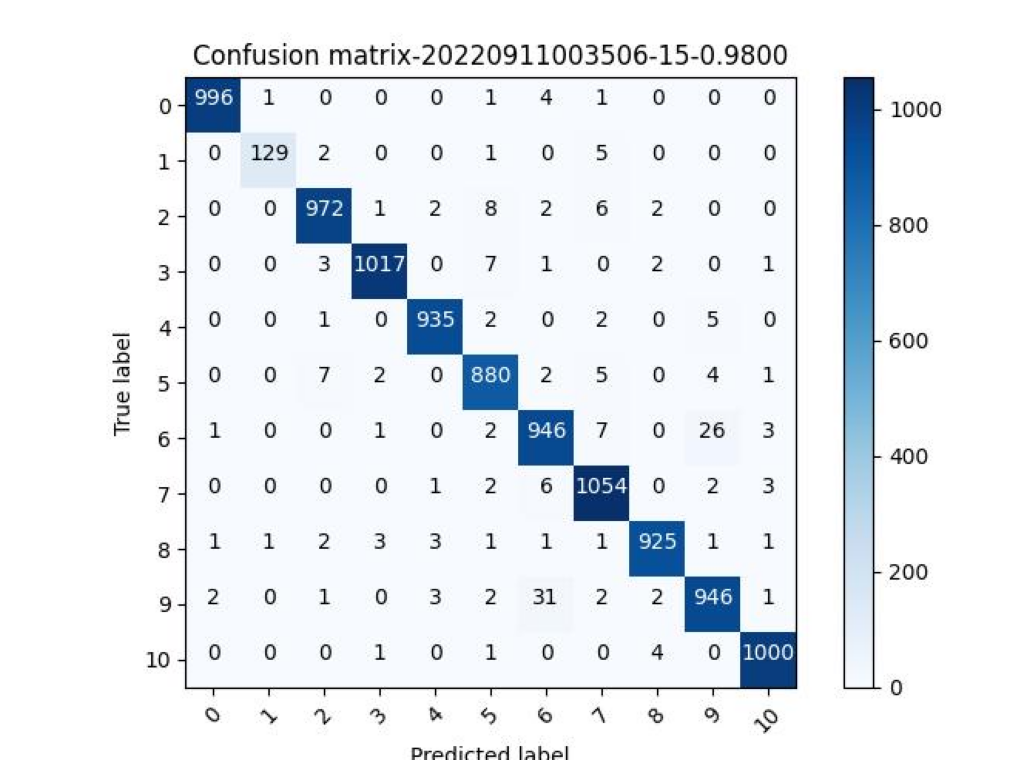

<Figure size 432x288 with 0 Axes>

In [19]:
# qqqqqqq = Image.open('./cm-20220911003506-15-0.9800000000000001.jpg')
# fig, ax = plt.subplots(dpi=200)
# ax.imshow(qqqqqqq)
# ax.axis('off')
# plt.tight_layout()
# plt.show()
# plt.clf()

제출에 사용한 checkpoint의 confusion matrix입니다(validation set).

회전되었을 때 구분하기 어려운 **"6"과 "9"를 잘 구분하지 못하는 것 같아 아쉽습니다.**

<hr/>

TTA를 적용하면 0.1~0.5(/100)점 정도 public 점수가 소폭 상승합니다.

큰 의미는 없어 보이지만 추론 시간 제한이 없는 대회이므로 적용했습니다.

약 1시간 정도 소요됩니다.

**모델이 노이즈 클래스인 "10"으로 예측한 경우 원래 클래스인 "1"로 변경하여 투표를 진행합니다.**

In [7]:
device =  torch.device("cuda")
checkpoint = f'./runs/{run_id}/best_model(epoch15).pt'
model = torch.load(checkpoint)
model.to(device)
model.eval()

test_preds = []

with torch.no_grad():
    for x in tqdm(iter(dataloaders['test'])):
        tta_preds = []

        for i, transformer in enumerate(transform_TTA):
            augmented_x = transformer.augment_image(x)
            augmented_x = augmented_x.to(device)
            batch_pred = model(augmented_x)
            _, pred = torch.max(batch_pred, 1)
            pred = pred.detach().cpu().numpy().tolist()

            for j, p in enumerate(pred):
                if p == 10:
                    pred[j] = 1

            tta_preds.append(pred)
        
        cols = list(zip(*tta_preds))
        for c in cols:
            most = Counter(c).most_common()[0][0]
            test_preds.append(most)

sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['label'] = test_preds
os.makedirs('./output/', exist_ok=True)
sample_submission.to_csv(f'./output/{run_id}.csv', index=False)

100%|██████████| 625/625 [59:20<00:00,  5.70s/it]


신기하게도 Validation accuracy보다 Public score가 항상 더 높게 나왔습니다.

**Val_acc: 0.98 / Public: 0.98583 / Private: 0.9831**

**감사합니다.**

#### 번외

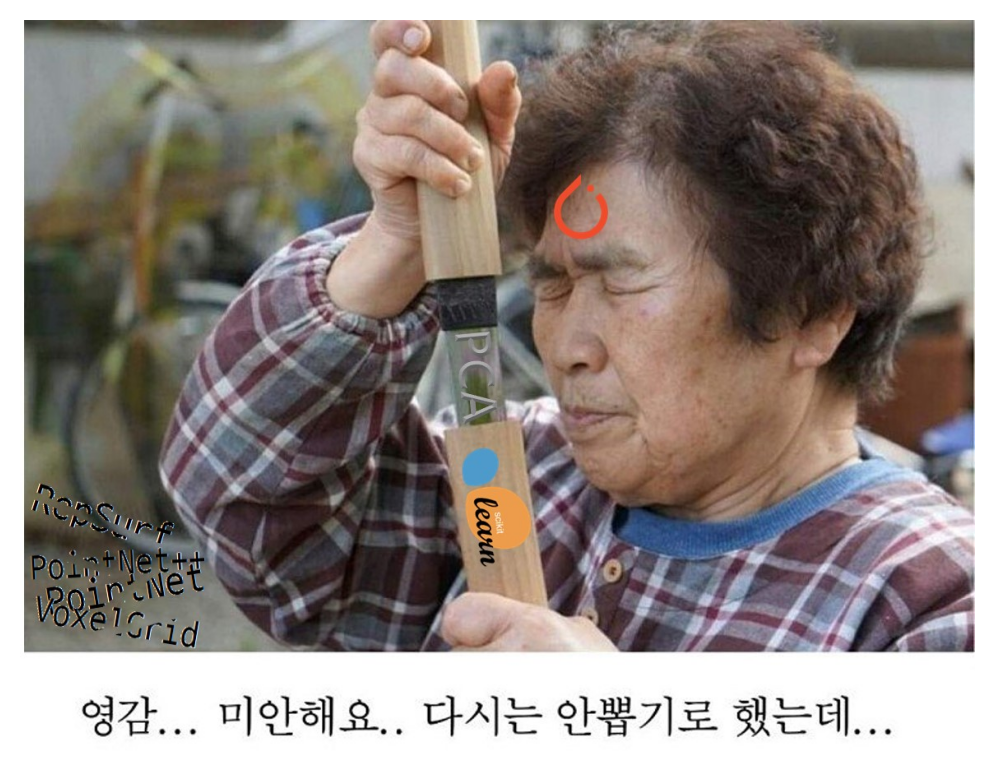

<Figure size 432x288 with 0 Axes>

In [20]:
# qqqqqqqq = Image.open('./qwerty.jpg')
# fig, ax = plt.subplots(dpi=200)
# ax.imshow(qqqqqqqq)
# ax.axis('off')
# plt.tight_layout()
# plt.show()
# plt.clf()